### Import Libraries

In [139]:
# Import standard libraries
import os, datetime
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pl
import igraph
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import hvplot.pandas
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')
%matplotlib inline

import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import seaborn as sb
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
# import cairo
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import zscore
from scipy.sparse.linalg import norm
import networkx as nx
from pyvis.network import Network

## Load environment variables from .env file and find project root
import sys
from dotenv import load_dotenv, find_dotenv
load_dotenv()
PROJECT_ROOT = Path(find_dotenv()).parent
# data_path = Path(PROJECT_ROOT, 'results', 'eyemap')
store_path = Path(PROJECT_ROOT, 'results','AOTU_Connectivity')
sys.path.append(str(PROJECT_ROOT.joinpath('src')))


from utils import olc_client
c = olc_client.connect(verbose=True)

from utils.celltype_conn_by_roi import CelltypeConnByRoi
from utils.celltype_conn_plotter import CelltypeConnPlotter
from utils.plotter import plot_cns, save_figure, get_skeletons, get_skeleton, get_meshes, get_mesh, show_figure
from utils.helper import slugify
from utils.neuron_bag import NeuronBag

# Import neuPrint specific libraries
from neuprint import Client, fetch_neurons, NeuronCriteria as NC, fetch_neurons, fetch_simple_connections, fetch_adjacencies, connection_table_to_matrix, merge_neuron_properties, NotNull, fetch_synapse_connections, fetch_neurons,fetch_primary_rois, fetch_all_rois, fetch_synapses, fetch_roi_hierarchy
from neuprint.utils import connection_table_to_matrix

Loading BokehJS ...

Connected to https://neuprint-cns.janelia.org[cns].
Client: neuprint-python v1.7.4
User: aishahamid201@gmail.com [readwrite]



### LC inputs to AOTUs

In [140]:
# Fetch LC10 neurons and get their types, fetch AOTU neurons and get their types
neurons_df_LC,roi_df = fetch_neurons(NC(type='^LC.*'))

neurons_df_AOTU,roi_df = fetch_neurons(NC(type='^AOTU.*'))

neurons_df_LC, neurons_df_AOTU

(         bodyId             instance    type   pre  post  downstream  \
 0         10573              LC10a_L   LC10a   375  1295        2650   
 1         11153               LC22_R    LC22   277  1760        1902   
 2         11372                LC9_R     LC9   269   708        1787   
 3         11516  LCNOpm(LAL-NO3pm)_L  LCNOpm  1048  9104        9648   
 4         11692               LC12_L    LC12   220   424        1378   
 ...         ...                  ...     ...   ...   ...         ...   
 4251     915658              LC10d_L   LC10d   242   793        1860   
 4252     919862              LC10d_L   LC10d   179   556        1193   
 4253  104486473               LC28_L    LC28   274   864        2278   
 4254  212467981              LC10d_L   LC10d   200   627        1443   
 4255  882274915               LC28_L    LC28   230   829        1953   
 
       upstream        size  status            statusLabel  ... dimorphism  \
 0         1295   569927082  Traced  Prelim 

In [141]:
LC_celltypes = neurons_df_LC['type'].unique()
AOTU_celltypes = neurons_df_AOTU['type'].unique()

LC_celltypes, AOTU_celltypes

(array(['LC10a', 'LC22', 'LC9', 'LCNOpm', 'LC12', 'LC11', 'LC31b', 'LC4',
        'LC14a-1', 'LC33', 'LC10c-2', 'LC17', 'LC10d', 'LC23', 'LC31a',
        'LC36', 'LC20b', 'LC18', 'LC26', 'LC21', 'LC39b', 'LC19', 'LC15',
        'LC14b', 'LC25', 'LC10c-1', 'LC29', 'LC6', 'LC14a-2', 'LC13',
        'LC43', 'LC16', 'LC37', 'LC40', 'LC35a', 'LC39a', 'LC35b', 'LC10e',
        'LC24', 'LC28', 'LC34', 'LC44', 'LC41', 'LC10b', 'LCNOp', 'LC30',
        'LC10_unclear', 'LC20a', 'LC46b', 'LC27'], dtype=object),
 array(['AOTU019', 'AOTU041', 'AOTU042', 'AOTU023', 'AOTU012', 'AOTU035',
        'AOTU005', 'AOTU100m', 'AOTU016_c', 'AOTU061', 'AOTU052',
        'AOTU103m', 'AOTU063_b', 'AOTU064', 'AOTU033', 'AOTU101m',
        'AOTU063_a', 'AOTU049', 'AOTU027', 'AOTU014', 'AOTU015', 'AOTU046',
        'AOTU050', 'AOTU024', 'AOTU059', 'AOTU009', 'AOTU008', 'AOTU045',
        'AOTU065', 'AOTU007_c', 'AOTU002_c', 'AOTU029', 'AOTU016_a',
        'AOTU002_a', 'AOTU026', 'AOTU020', 'AOTU017', 'AOTU028',
   

In [142]:
#  Define pre- and post-synaptic cell types
celltypes_pre = LC_celltypes
celltypes_post = AOTU_celltypes
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_LC_AOTU_df = merge_neuron_properties(neu_df, conn_df)

conn_LC_AOTU_df


  0%|          | 0/2 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10573,10070,AOTU(L),145,LC10a,LC10a_L,AOTU019,AOTU019_L
1,10573,10148,AOTU(L),51,LC10a,LC10a_L,AOTU041,AOTU041_L
2,10573,10219,AOTU(L),78,LC10a,LC10a_L,AOTU023,AOTU023_L
3,10573,10502,AOTU(L),30,LC10a,LC10a_L,AOTU041,AOTU041_L
4,10573,11370,AOTU(L),49,LC10a,LC10a_L,AOTU063_b,AOTU063_b_L
...,...,...,...,...,...,...,...,...
22130,212467981,518657,AOTU(L),5,LC10d,LC10d_L,AOTU008,AOTU008_L
22131,212467981,520903,AOTU(L),13,LC10d,LC10d_L,AOTU002_b,AOTU002_b_L
22132,212467981,520905,AOTU(L),14,LC10d,LC10d_L,AOTU008,AOTU008_L
22133,212467981,531863,AOTU(L),56,LC10d,LC10d_L,AOTU012,AOTU012_L


In [143]:
# Group by type combinations and sum the weights
conn_LC_AOTU_df_type = conn_LC_AOTU_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

conn_LC_AOTU_df_type

,type_pre,type_post,weight
0,LC10_unclear,AOTU001,103
1,LC10_unclear,AOTU002_a,228
2,LC10_unclear,AOTU002_b,3
3,LC10_unclear,AOTU002_c,40
4,LC10_unclear,AOTU013,9
...,...,...,...
354,LC46b,AOTU052,5
355,LC46b,AOTU064,6
356,LC6,AOTU009,351
357,LC9,AOTU045,6


In [144]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_LC_AOTU_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)


conn_LC_AOTU_df_type_sort = conn_LC_AOTU_df_type.sort_values(by='weight', ascending=False)

#filter for only strong connections
conn_LC_AOTU_df_type_top = conn_LC_AOTU_df_type_sort[conn_LC_AOTU_df_type_sort['weight']>300]



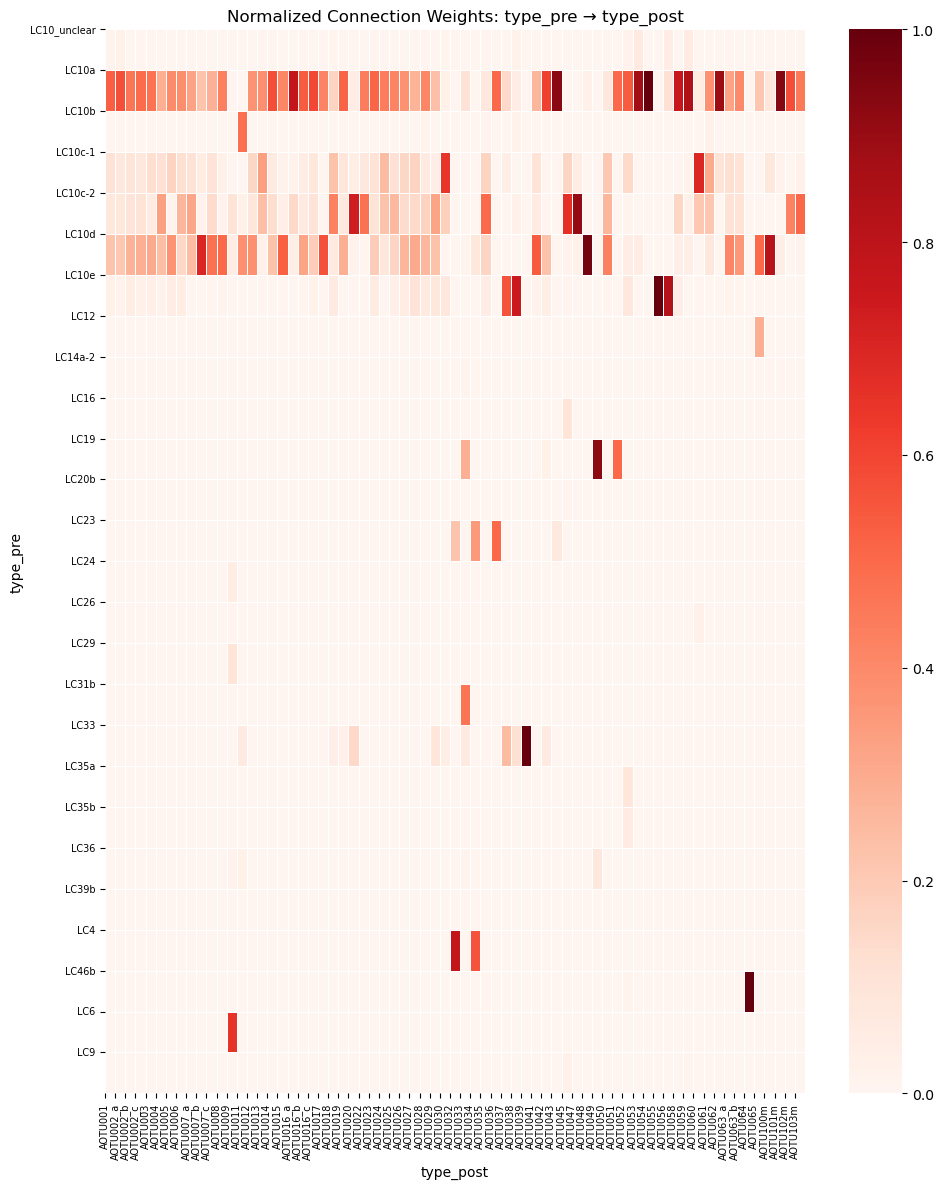

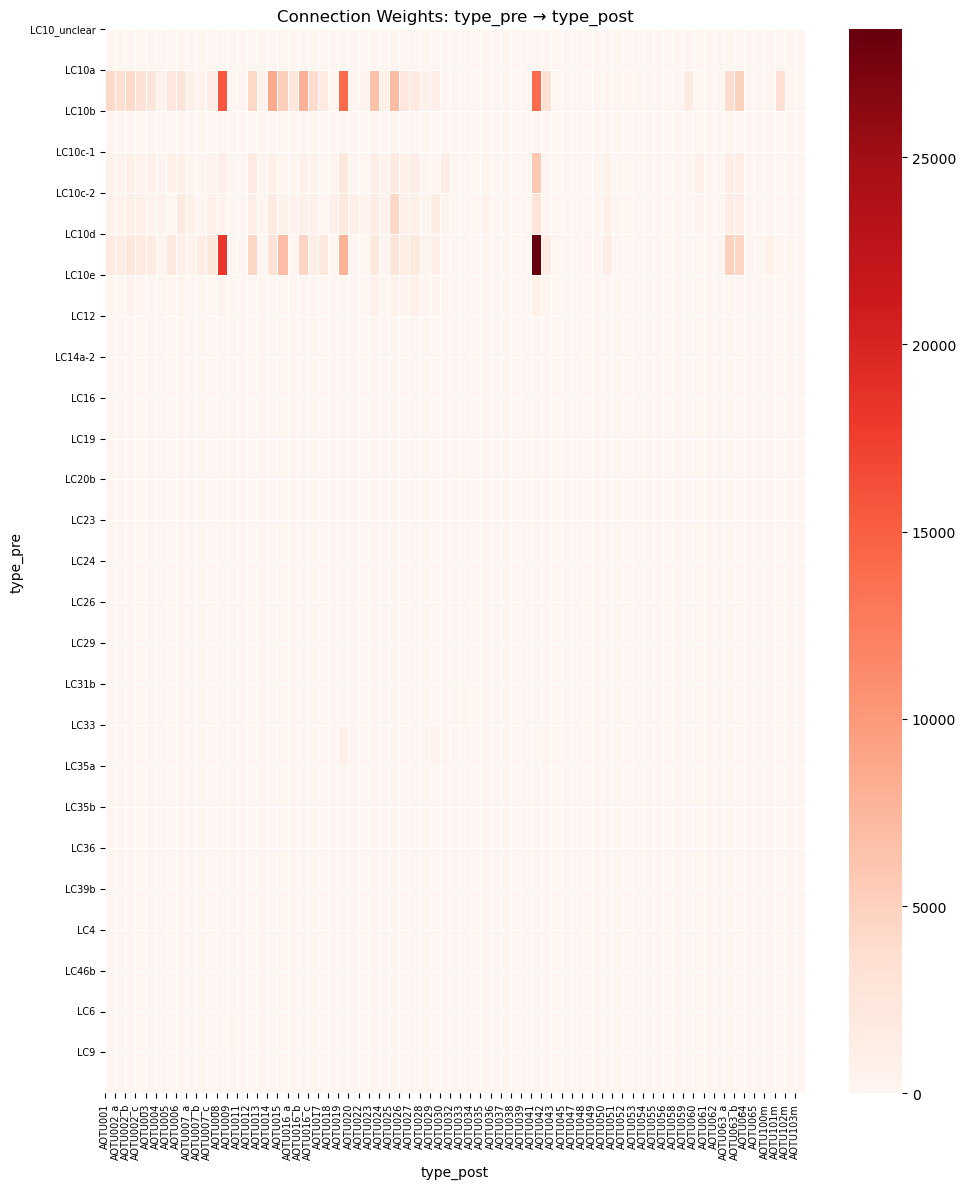

In [146]:
# Pivot the DataFrame to a matrix format
# matrix_df = conn_AOTU_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 12))
ax = sb.heatmap(norm_matrix_df, cmap='Reds', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Normalized Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()


# Not Normalized
# Create the heatmap
plt.figure(figsize=(10, 12))
ax = sb.heatmap(matrix_df, cmap='Reds', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(matrix_df.index)))
ax.set_yticklabels(matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(matrix_df.columns)))
ax.set_xticklabels(matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

# Interactive heatmap:




# Assume matrix_df and norm_matrix_df are your non-normalized and normalized dataframes

def plot_interactive_heatmap(df, title):
    fig = go.Figure(data=go.Heatmap(
        z=df.values,
        x=df.columns,
        y=df.index,
        colorscale='Reds',
        hoverongaps=False,
        hovertemplate='type_pre: %{y}<br>type_post: %{x}<br>weight: %{z}<extra></extra>'
    ))

    fig.update_layout(
        title=title,
        xaxis_title='type_post',
        yaxis_title='type_pre',
        width=800,
        height=1000
    )

    fig.show()

# Interactive heatmap for normalized weights
plot_interactive_heatmap(norm_matrix_df, 'Normalized Connection Weights: type_pre → type_post')

# Interactive heatmap for raw weights
plot_interactive_heatmap(matrix_df, 'Connection Weights: type_pre → type_post')





### LC10 inputs to AOTUs

In [126]:
# Fetch LC10 neurons and get their types, fetch AOTU neurons and get their types
neurons_df_LC10,roi_df = fetch_neurons(NC(type='^LC10.*'))

neurons_df_AOTU,roi_df = fetch_neurons(NC(type='^AOTU.*'))

In [127]:
neurons_df_LC10, neurons_df_AOTU

(        bodyId   instance     type  pre  post  downstream  upstream  \
 0        10573    LC10a_L    LC10a  375  1295        2650      1295   
 1        12130    LC10a_L    LC10a  328  1282        2365      1282   
 2        12424    LC10a_L    LC10a  359  1232        2428      1232   
 3        12458    LC10a_L    LC10a  372  1542        2612      1542   
 4        12783  LC10c-2_L  LC10c-2  122   583         837       583   
 ..         ...        ...      ...  ...   ...         ...       ...   
 954     580484    LC10d_L    LC10d  208   741        1431       741   
 955     580987    LC10b_L    LC10b  148   797         990       797   
 956     915658    LC10d_L    LC10d  242   793        1860       793   
 957     919862    LC10d_L    LC10d  179   556        1193       556   
 958  212467981    LC10d_L    LC10d  200   627        1443       627   
 
           size  status            statusLabel  ... dimorphism  \
 0    569927082  Traced  Prelim Roughly traced  ...       None   
 1

In [128]:
LC10_celltypes = neurons_df_LC10['type'].unique()
AOTU_celltypes = neurons_df_AOTU['type'].unique()

In [129]:
LC10_celltypes, AOTU_celltypes

(array(['LC10a', 'LC10c-2', 'LC10d', 'LC10c-1', 'LC10e', 'LC10b',
        'LC10_unclear'], dtype=object),
 array(['AOTU019', 'AOTU041', 'AOTU042', 'AOTU023', 'AOTU012', 'AOTU035',
        'AOTU005', 'AOTU100m', 'AOTU016_c', 'AOTU061', 'AOTU052',
        'AOTU103m', 'AOTU063_b', 'AOTU064', 'AOTU033', 'AOTU101m',
        'AOTU063_a', 'AOTU049', 'AOTU027', 'AOTU014', 'AOTU015', 'AOTU046',
        'AOTU050', 'AOTU024', 'AOTU059', 'AOTU009', 'AOTU008', 'AOTU045',
        'AOTU065', 'AOTU007_c', 'AOTU002_c', 'AOTU029', 'AOTU016_a',
        'AOTU002_a', 'AOTU026', 'AOTU020', 'AOTU017', 'AOTU028',
        'AOTU016_b', 'AOTU036', 'AOTU006', 'AOTU043', 'AOTU048', 'AOTU013',
        'AOTU051', 'AOTU034', 'AOTU011', 'AOTU002_b', 'AOTU022', 'AOTU062',
        'AOTU032', 'AOTU001', 'AOTU007_b', 'AOTU047', 'AOTU003',
        'AOTU007_a', 'AOTU054', 'AOTU030', 'AOTU056', 'AOTU055', 'AOTU060',
        'AOTU102m', 'AOTU038', 'AOTU058', 'AOTU053', 'AOTU037', 'AOTU018',
        'AOTU004', 'AOTU039', 'AOTU

In [130]:
#  Define pre- and post-synaptic cell types
celltypes_pre = LC10_celltypes
celltypes_post = AOTU_celltypes
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_LC10_AOTU_df = merge_neuron_properties(neu_df, conn_df)


  0%|          | 0/2 [00:00<?, ?it/s]

In [131]:
conn_LC10_AOTU_df

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10573,10070,AOTU(L),145,LC10a,LC10a_L,AOTU019,AOTU019_L
1,10573,10148,AOTU(L),51,LC10a,LC10a_L,AOTU041,AOTU041_L
2,10573,10219,AOTU(L),78,LC10a,LC10a_L,AOTU023,AOTU023_L
3,10573,10502,AOTU(L),30,LC10a,LC10a_L,AOTU041,AOTU041_L
4,10573,11370,AOTU(L),49,LC10a,LC10a_L,AOTU063_b,AOTU063_b_L
...,...,...,...,...,...,...,...,...
21743,212467981,518657,AOTU(L),5,LC10d,LC10d_L,AOTU008,AOTU008_L
21744,212467981,520903,AOTU(L),13,LC10d,LC10d_L,AOTU002_b,AOTU002_b_L
21745,212467981,520905,AOTU(L),14,LC10d,LC10d_L,AOTU008,AOTU008_L
21746,212467981,531863,AOTU(L),56,LC10d,LC10d_L,AOTU012,AOTU012_L


In [132]:
# Group by type combinations and sum the weights
conn_LC10_AOTU_df_type = conn_LC10_AOTU_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

In [133]:
conn_LC10_AOTU_df_type

,type_pre,type_post,weight
0,LC10_unclear,AOTU001,103
1,LC10_unclear,AOTU002_a,228
2,LC10_unclear,AOTU002_b,3
3,LC10_unclear,AOTU002_c,40
4,LC10_unclear,AOTU013,9
...,...,...,...
292,LC10e,AOTU056,48
293,LC10e,AOTU058,3
294,LC10e,AOTU060,7
295,LC10e,AOTU063_a,144


In [134]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_LC10_AOTU_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)

In [135]:

conn_LC10_AOTU_df_type_sort = conn_LC10_AOTU_df_type.sort_values(by='weight', ascending=False)

In [136]:
#filter for only strong connections
conn_LC10_AOTU_df_type_top = conn_LC10_AOTU_df_type_sort[conn_LC10_AOTU_df_type_sort['weight']>300]

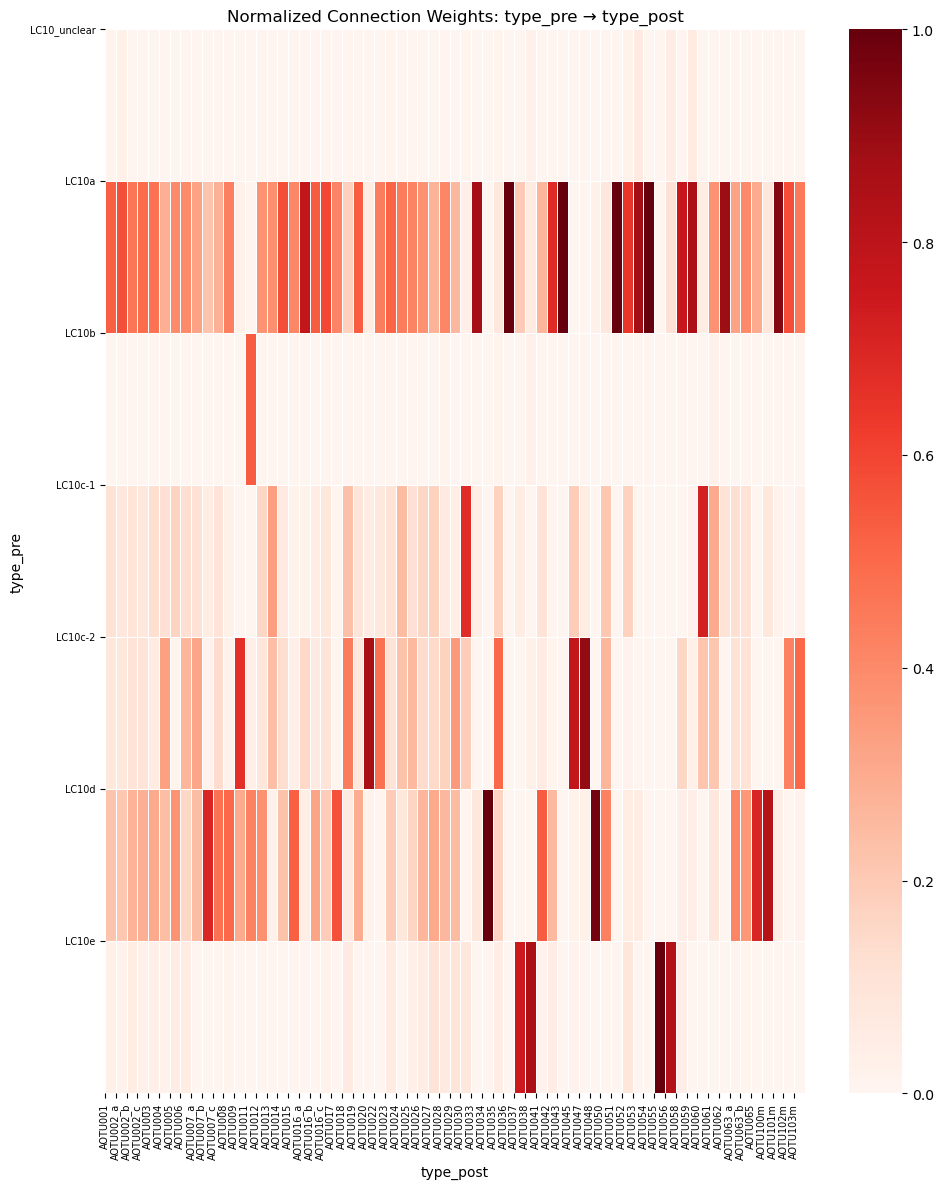

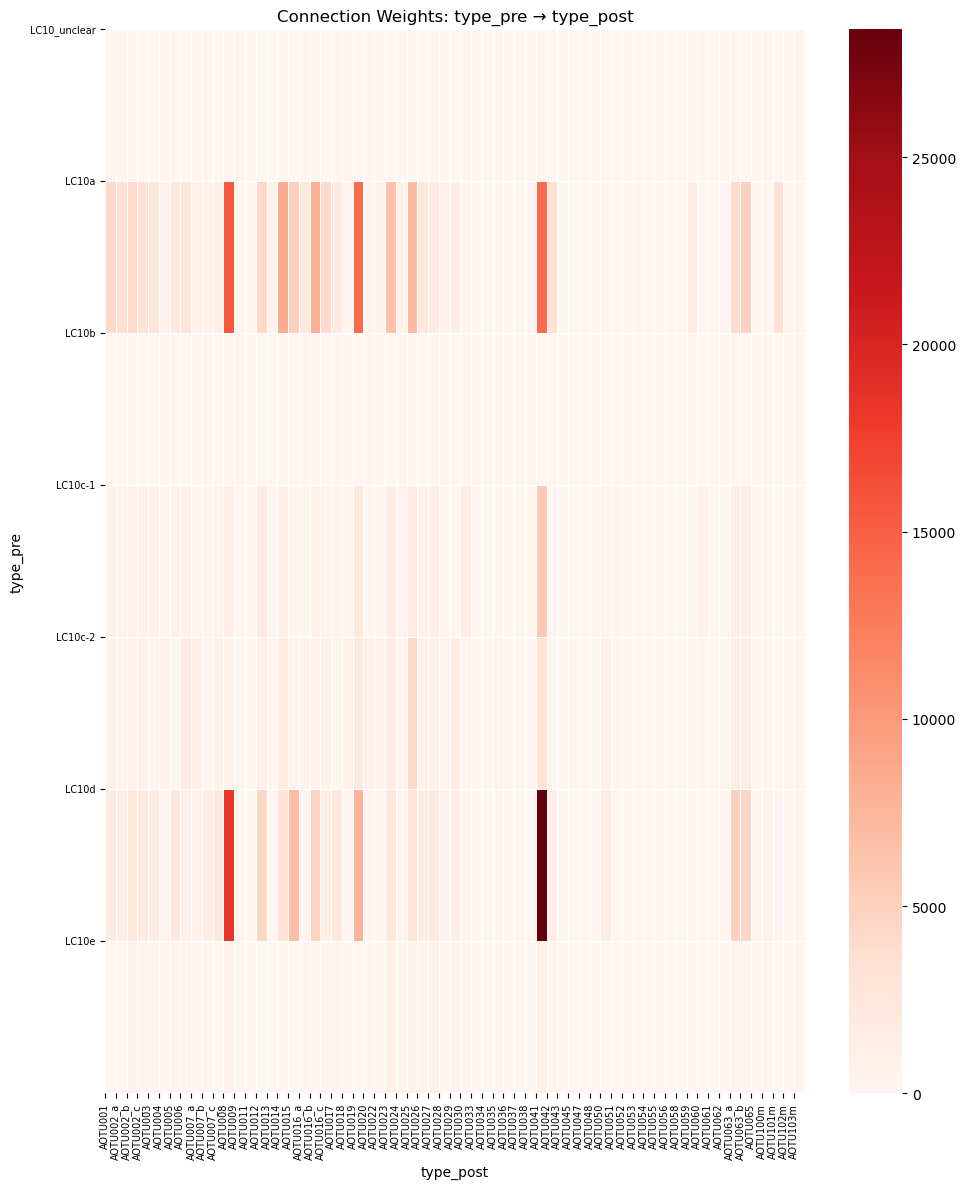

In [138]:
# Pivot the DataFrame to a matrix format
# matrix_df = conn_AOTU_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 12))
ax = sb.heatmap(norm_matrix_df, cmap='Reds', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Normalized Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

# Not Normalized 
# Create the heatmap
plt.figure(figsize=(10, 12))
ax = sb.heatmap(matrix_df, cmap='Reds', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(matrix_df.index)))
ax.set_yticklabels(matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(matrix_df.columns)))
ax.set_xticklabels(matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()




### LC10 inputs for AOTU041/AOTU016_b, 
### Change name accordingly

In [77]:
#  Define pre- and post-synaptic cell types
celltypes_pre = LC10_celltypes
celltypes_post = 'AOTU016_b'
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_LC10_AOTU016_b_df = merge_neuron_properties(neu_df, conn_df)




In [78]:
conn_LC10_AOTU016_b_df

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10573,23775,AOTU(L),40,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
1,10573,25830,AOTU(L),10,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
2,10573,46259,AOTU(L),8,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
3,10573,98923,AOTU(L),3,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
4,12130,23775,AOTU(L),6,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
...,...,...,...,...,...,...,...,...
801,575597,46259,AOTU(L),6,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
802,575597,98923,AOTU(L),40,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
803,212467981,25830,AOTU(L),14,LC10d,LC10d_L,AOTU016_b,AOTU016_b_L
804,212467981,46259,AOTU(L),8,LC10d,LC10d_L,AOTU016_b,AOTU016_b_L


In [79]:
# Group by type combinations and sum the weights
conn_LC10_AOTU016_b_df_type = conn_LC10_AOTU016_b_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

In [80]:
conn_LC10_AOTU016_b_df_type

,type_pre,type_post,weight
0,LC10_unclear,AOTU016_b,105
1,LC10a,AOTU016_b,8073
2,LC10c-1,AOTU016_b,801
3,LC10c-2,AOTU016_b,946
4,LC10d,AOTU016_b,4782
5,LC10e,AOTU016_b,162


In [81]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_LC10_AOTU016_b_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)

conn_LC10_AOTU016_b_df_type_sort = conn_LC10_AOTU016_b_df_type.sort_values(by='weight', ascending=False)

#filter for only strong connections
conn_LC10_AOTU016_b_df_type_top = conn_LC10_AOTU016_b_df_type_sort[conn_LC10_AOTU016_b_df_type_sort['weight']>300]



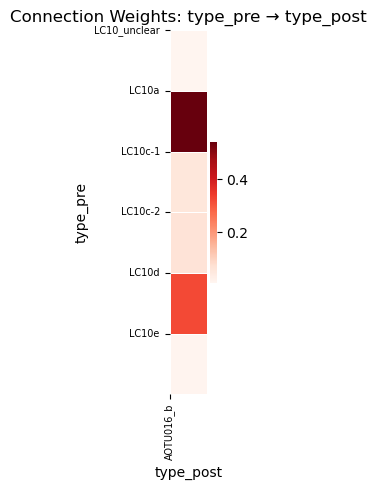

In [82]:
# Pivot the DataFrame to a matrix format
# matrix_df = conn_AOTU_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Create the heatmap
plt.figure(figsize=(2, 5))
ax = sb.heatmap(norm_matrix_df, cmap='Reds', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

### Intra-LC10 connectivity

In [35]:
#  Define pre- and post-synaptic cell types
celltypes_pre = LC10_celltypes
celltypes_post = LC10_celltypes
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_LC10_df = merge_neuron_properties(neu_df, conn_df)


  0%|          | 0/5 [00:00<?, ?it/s]

In [37]:
conn_LC10_df

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10573,12130,AOTU(L),4,LC10a,LC10a_L,LC10a,LC10a_L
1,10573,13697,AOTU(L),3,LC10a,LC10a_L,LC10a,LC10a_L
2,10573,15181,AOTU(L),3,LC10a,LC10a_L,LC10d,LC10d_L
3,10573,17693,AOTU(L),3,LC10a,LC10a_L,LC10c-1,LC10c-1_L
4,10573,21744,AOTU(L),3,LC10a,LC10a_L,LC10a,LC10a_L
...,...,...,...,...,...,...,...,...
14597,212467981,14980,AOTU(L),3,LC10d,LC10d_L,LC10a,LC10a_L
14598,212467981,14980,Optic-unspecified(L),3,LC10d,LC10d_L,LC10a,LC10a_L
14599,212467981,66760,AOTU(L),5,LC10d,LC10d_L,LC10e,LC10e_L
14600,212467981,150060,AOTU(L),9,LC10d,LC10d_L,LC10d,LC10d_L


In [38]:
# Group by type combinations and sum the weights
conn_LC10_df_type = conn_LC10_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

In [39]:
conn_LC10_df_type

,type_pre,type_post,weight
0,LC10_unclear,LC10_unclear,37
1,LC10_unclear,LC10a,482
2,LC10_unclear,LC10c-1,10
3,LC10_unclear,LC10d,233
4,LC10a,LC10_unclear,301
5,LC10a,LC10a,20528
6,LC10a,LC10b,32
7,LC10a,LC10c-1,1209
8,LC10a,LC10c-2,910
9,LC10a,LC10d,11000


In [40]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_LC10_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)

In [42]:

conn_LC10_df_type_sort = conn_LC10_df_type.sort_values(by='weight', ascending=False)

#filter for only strong connections
conn_LC10_df_type_top = conn_LC10_df_type_sort[conn_LC10_df_type_sort['weight']>300]

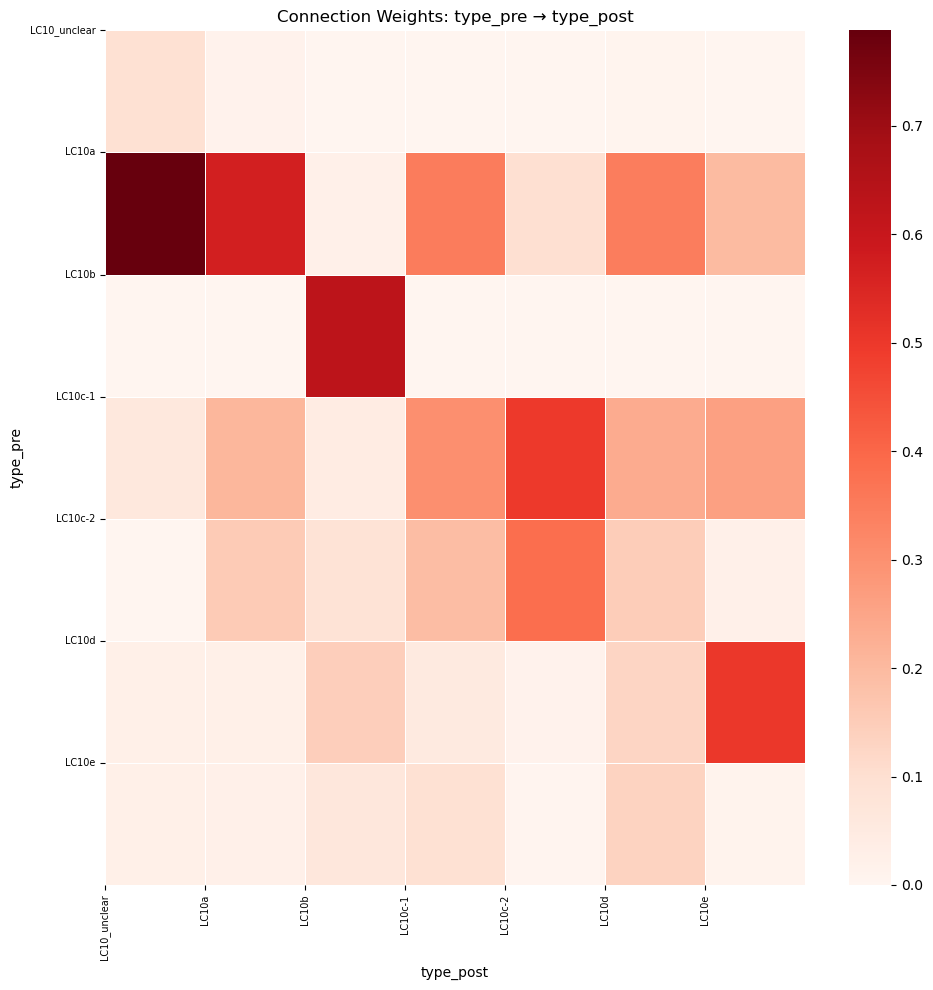

In [43]:
# Pivot the DataFrame to a matrix format
# matrix_df = conn_AOTU_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 10))
ax = sb.heatmap(norm_matrix_df, cmap='Reds', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

### All LCs and AOTU041

In [59]:
#  Define pre- and post-synaptic cell types
celltypes_pre = LC_celltypes
celltypes_post = 'AOTU041'
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_LC_AOTU041_df = merge_neuron_properties(neu_df, conn_df)


In [60]:
conn_LC_AOTU041_df

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10573,10148,AOTU(L),51,LC10a,LC10a_L,AOTU041,AOTU041_L
1,10573,10502,AOTU(L),30,LC10a,LC10a_L,AOTU041,AOTU041_L
2,12130,10148,AOTU(L),28,LC10a,LC10a_L,AOTU041,AOTU041_L
3,12130,10502,AOTU(L),40,LC10a,LC10a_L,AOTU041,AOTU041_L
4,12424,10148,AOTU(L),43,LC10a,LC10a_L,AOTU041,AOTU041_L
...,...,...,...,...,...,...,...,...
1791,919862,10502,AOTU(L),42,LC10d,LC10d_L,AOTU041,AOTU041_L
1792,919862,523317,AOTU(L),3,LC10d,LC10d_L,AOTU041,AOTU041_R
1793,212467981,10031,AOTU(L),3,LC10d,LC10d_L,AOTU041,AOTU041_R
1794,212467981,10148,AOTU(L),49,LC10d,LC10d_L,AOTU041,AOTU041_L


In [ ]:
# Group by type combinations and sum the weights
conn_LC_AOTU041_df_type = conn_LC_AOTU041_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

In [63]:
conn_LC_AOTU041_df_type

,type_pre,type_post,weight
0,LC10_unclear,AOTU041,113
1,LC10a,AOTU041,14180
2,LC10b,AOTU041,73
3,LC10c-1,AOTU041,5836
4,LC10c-2,AOTU041,3188
5,LC10d,AOTU041,28415
6,LC10e,AOTU041,998
7,LC33,AOTU041,36


In [65]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_LC_AOTU041_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)

In [66]:
conn_LC_AOTU041_df_type_sort = conn_LC_AOTU041_df_type.sort_values(by='weight', ascending=False)

#filter for only strong connections
conn_LC_AOTU041_df_type_top = conn_LC_AOTU041_df_type_sort[conn_LC_AOTU041_df_type_sort['weight']>300]

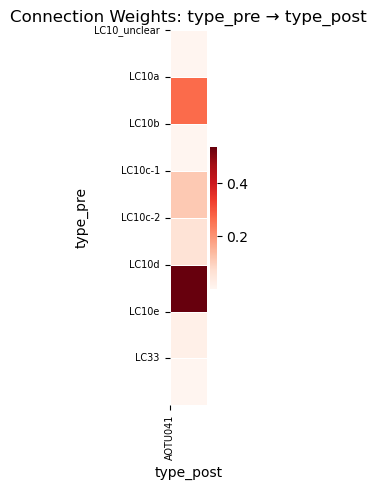

In [68]:
# Pivot the DataFrame to a matrix format
# matrix_df = conn_AOTU_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Create the heatmap
plt.figure(figsize=(2, 5))
ax = sb.heatmap(norm_matrix_df, cmap='Reds', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

### All LCs and AOTU016_b

In [70]:
#  Define pre- and post-synaptic cell types
celltypes_pre = LC_celltypes
celltypes_post = 'AOTU016_b'
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_LC_AOTU016_b_df = merge_neuron_properties(neu_df, conn_df)

conn_LC_AOTU016_b_df

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10573,23775,AOTU(L),40,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
1,10573,25830,AOTU(L),10,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
2,10573,46259,AOTU(L),8,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
3,10573,98923,AOTU(L),3,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
4,12130,23775,AOTU(L),6,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
...,...,...,...,...,...,...,...,...
805,575597,46259,AOTU(L),6,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
806,575597,98923,AOTU(L),40,LC10a,LC10a_L,AOTU016_b,AOTU016_b_L
807,212467981,25830,AOTU(L),14,LC10d,LC10d_L,AOTU016_b,AOTU016_b_L
808,212467981,46259,AOTU(L),8,LC10d,LC10d_L,AOTU016_b,AOTU016_b_L


In [74]:
# Group by type combinations and sum the weights
conn_LC_AOTU016_b_df_type = conn_LC_AOTU016_b_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

conn_LC_AOTU016_b_df_type

,type_pre,type_post,weight
0,LC10_unclear,AOTU016_b,105
1,LC10a,AOTU016_b,8073
2,LC10c-1,AOTU016_b,801
3,LC10c-2,AOTU016_b,946
4,LC10d,AOTU016_b,4782
5,LC10e,AOTU016_b,162
6,LC19,AOTU016_b,14


In [75]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_LC_AOTU016_b_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)


conn_LC_AOTU016_b_df_type_sort = conn_LC_AOTU016_b_df_type.sort_values(by='weight', ascending=False)

#filter for only strong connections
conn_LC_AOTU016_b_df_type_top = conn_LC_AOTU016_b_df_type_sort[conn_LC_AOTU016_b_df_type_sort['weight']>300]



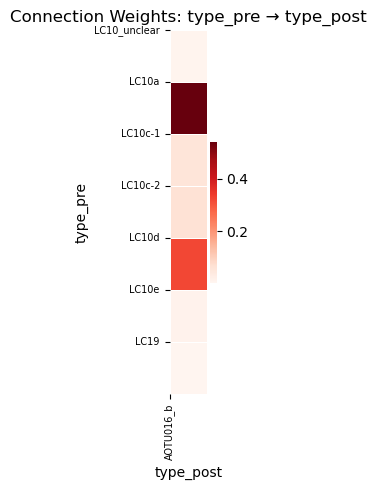

In [76]:
# Pivot the DataFrame to a matrix format
# matrix_df = conn_AOTU_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Create the heatmap
plt.figure(figsize=(2, 5))
ax = sb.heatmap(norm_matrix_df, cmap='Reds', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

### AOTUs connecting back to LCs


In [109]:
LC_celltypes = neurons_df_LC['type'].unique()
AOTU_celltypes = neurons_df_AOTU['type'].unique()

LC_celltypes, AOTU_celltypes

(array(['LC10a', 'LC22', 'LC9', 'LCNOpm', 'LC12', 'LC11', 'LC31b', 'LC4',
        'LC14a-1', 'LC33', 'LC10c-2', 'LC17', 'LC10d', 'LC23', 'LC31a',
        'LC36', 'LC20b', 'LC18', 'LC26', 'LC21', 'LC39b', 'LC19', 'LC15',
        'LC14b', 'LC25', 'LC10c-1', 'LC29', 'LC6', 'LC14a-2', 'LC13',
        'LC43', 'LC16', 'LC37', 'LC40', 'LC35a', 'LC39a', 'LC35b', 'LC10e',
        'LC24', 'LC28', 'LC34', 'LC44', 'LC41', 'LC10b', 'LCNOp', 'LC30',
        'LC10_unclear', 'LC20a', 'LC46b', 'LC27'], dtype=object),
 array(['AOTU019', 'AOTU041', 'AOTU042', 'AOTU023', 'AOTU012', 'AOTU035',
        'AOTU005', 'AOTU100m', 'AOTU016_c', 'AOTU061', 'AOTU052',
        'AOTU103m', 'AOTU063_b', 'AOTU064', 'AOTU033', 'AOTU101m',
        'AOTU063_a', 'AOTU049', 'AOTU027', 'AOTU014', 'AOTU015', 'AOTU046',
        'AOTU050', 'AOTU024', 'AOTU059', 'AOTU009', 'AOTU008', 'AOTU045',
        'AOTU065', 'AOTU007_c', 'AOTU002_c', 'AOTU029', 'AOTU016_a',
        'AOTU002_a', 'AOTU026', 'AOTU020', 'AOTU017', 'AOTU028',
   

In [110]:
#  Define pre- and post-synaptic cell types
celltypes_pre = AOTU_celltypes
celltypes_post = LC_celltypes
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_AOTU_LC_df = merge_neuron_properties(neu_df, conn_df)

conn_AOTU_LC_df


  0%|          | 0/2 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10005,13534,LAL(L),7,AOTU019,AOTU019_R,LC33,LC33_L
1,10031,13593,AOTU(L),10,AOTU041,AOTU041_R,LC10d,LC10d_L
2,10031,13697,AOTU(L),6,AOTU041,AOTU041_R,LC10a,LC10a_L
3,10031,13853,AOTU(L),13,AOTU041,AOTU041_R,LC10d,LC10d_L
4,10031,14037,AOTU(L),5,AOTU041,AOTU041_R,LC10d,LC10d_L
...,...,...,...,...,...,...,...,...
4614,543277,22981,LAL(L),5,AOTU018,AOTU018_L,LC33,LC33_L
4615,543277,517845,LAL(L),4,AOTU018,AOTU018_L,LC33,LC33_L
4616,552128,24608,CentralBrain-unspecified,3,AOTU003,AOTU003_L,LC33,LC33_R
4617,382559434,12359,LAL(R),33,AOTU001,AOTU001_L,LCNOpm,LCNOpm(LAL-NO3pm)_R


In [111]:
# Group by type combinations and sum the weights
conn_AOTU_LC_df_type = conn_AOTU_LC_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

conn_AOTU_LC_df_type

,type_pre,type_post,weight
0,AOTU001,LC33,83
1,AOTU001,LCNOp,4
2,AOTU001,LCNOpm,168
3,AOTU002_a,LC33,9
4,AOTU002_b,LC10d,3
...,...,...,...
101,AOTU063_a,LC10a,3
102,AOTU063_a,LC10d,6
103,AOTU063_b,LC10a,3
104,AOTU063_b,LC10d,7


In [113]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_AOTU_LC_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)


conn_AOTU_LC_df_type_sort = conn_AOTU_LC_df_type.sort_values(by='weight', ascending=False)

#filter for only strong connections
conn_AOTU_LC_df_type_top = conn_AOTU_LC_df_type_sort[conn_AOTU_LC_df_type_sort['weight']>300]



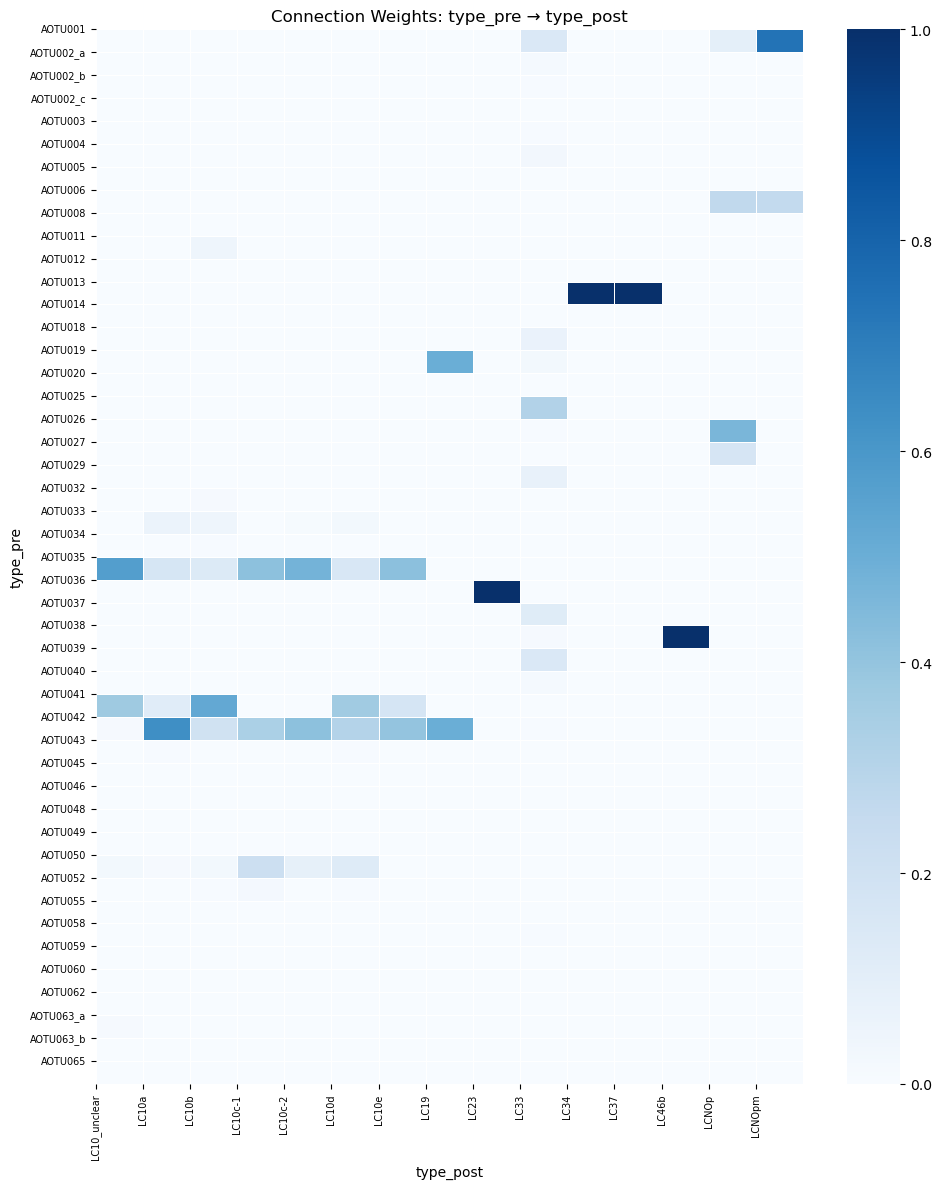

In [114]:
# Pivot the DataFrame to a matrix format
# matrix_df = conn_AOTU_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 12))
ax = sb.heatmap(norm_matrix_df, cmap='Blues', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

### AOTUs connecting back to LC10s


In [102]:
LC10_celltypes = neurons_df_LC10['type'].unique()
AOTU_celltypes = neurons_df_AOTU['type'].unique()

LC10_celltypes, AOTU_celltypes

(array(['LC10a', 'LC10c-2', 'LC10d', 'LC10c-1', 'LC10e', 'LC10b',
        'LC10_unclear'], dtype=object),
 array(['AOTU019', 'AOTU041', 'AOTU042', 'AOTU023', 'AOTU012', 'AOTU035',
        'AOTU005', 'AOTU100m', 'AOTU016_c', 'AOTU061', 'AOTU052',
        'AOTU103m', 'AOTU063_b', 'AOTU064', 'AOTU033', 'AOTU101m',
        'AOTU063_a', 'AOTU049', 'AOTU027', 'AOTU014', 'AOTU015', 'AOTU046',
        'AOTU050', 'AOTU024', 'AOTU059', 'AOTU009', 'AOTU008', 'AOTU045',
        'AOTU065', 'AOTU007_c', 'AOTU002_c', 'AOTU029', 'AOTU016_a',
        'AOTU002_a', 'AOTU026', 'AOTU020', 'AOTU017', 'AOTU028',
        'AOTU016_b', 'AOTU036', 'AOTU006', 'AOTU043', 'AOTU048', 'AOTU013',
        'AOTU051', 'AOTU034', 'AOTU011', 'AOTU002_b', 'AOTU022', 'AOTU062',
        'AOTU032', 'AOTU001', 'AOTU007_b', 'AOTU047', 'AOTU003',
        'AOTU007_a', 'AOTU054', 'AOTU030', 'AOTU056', 'AOTU055', 'AOTU060',
        'AOTU102m', 'AOTU038', 'AOTU058', 'AOTU053', 'AOTU037', 'AOTU018',
        'AOTU004', 'AOTU039', 'AOTU

In [103]:
#  Define pre- and post-synaptic cell types
celltypes_pre = AOTU_celltypes
celltypes_post = LC10_celltypes
#  Set connection weight threshold
threshold = 3
# Fetch synaptic connectivity between these types
neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)
# Merge with neuron properties to get types on both sides
conn_AOTU_LC10_df = merge_neuron_properties(neu_df, conn_df)

conn_AOTU_LC10_df


  0%|          | 0/2 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
0,10031,13593,AOTU(L),10,AOTU041,AOTU041_R,LC10d,LC10d_L
1,10031,13697,AOTU(L),6,AOTU041,AOTU041_R,LC10a,LC10a_L
2,10031,13853,AOTU(L),13,AOTU041,AOTU041_R,LC10d,LC10d_L
3,10031,14037,AOTU(L),5,AOTU041,AOTU041_R,LC10d,LC10d_L
4,10031,15181,AOTU(L),13,AOTU041,AOTU041_R,LC10d,LC10d_L
...,...,...,...,...,...,...,...,...
4512,531808,30188,AOTU(R),5,AOTU032,AOTU032_R,LC10d,LC10d_R
4513,531808,31677,AOTU(R),4,AOTU032,AOTU032_R,LC10d,LC10d_R
4514,531808,33094,AOTU(R),5,AOTU032,AOTU032_R,LC10d,LC10d_R
4515,531808,35587,AOTU(R),6,AOTU032,AOTU032_R,LC10d,LC10d_R


In [104]:
# Group by type combinations and sum the weights
conn_AOTU_LC10_df_type = conn_AOTU_LC10_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

conn_AOTU_LC10_df_type

,type_pre,type_post,weight
0,AOTU002_b,LC10d,3
1,AOTU002_c,LC10d,3
2,AOTU005,LC10e,5
3,AOTU008,LC10d,3
4,AOTU011,LC10b,34
...,...,...,...
73,AOTU063_a,LC10a,3
74,AOTU063_a,LC10d,6
75,AOTU063_b,LC10a,3
76,AOTU063_b,LC10d,7


In [105]:
# Pivot to create matrix form of the connection weights
matrix_df = conn_AOTU_LC10_df_type.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)
# Normalize each column (post-synaptic type) by its total input
norm_matrix_df = matrix_df.div(matrix_df.sum(axis=0), axis=1)


conn_AOTU_LC10_df_type_sort = conn_AOTU_LC10_df_type.sort_values(by='weight', ascending=False)

#filter for only strong connections
conn_AOTU_LC10_df_type_top = conn_AOTU_LC10_df_type_sort[conn_AOTU_LC10_df_type_sort['weight']>300]



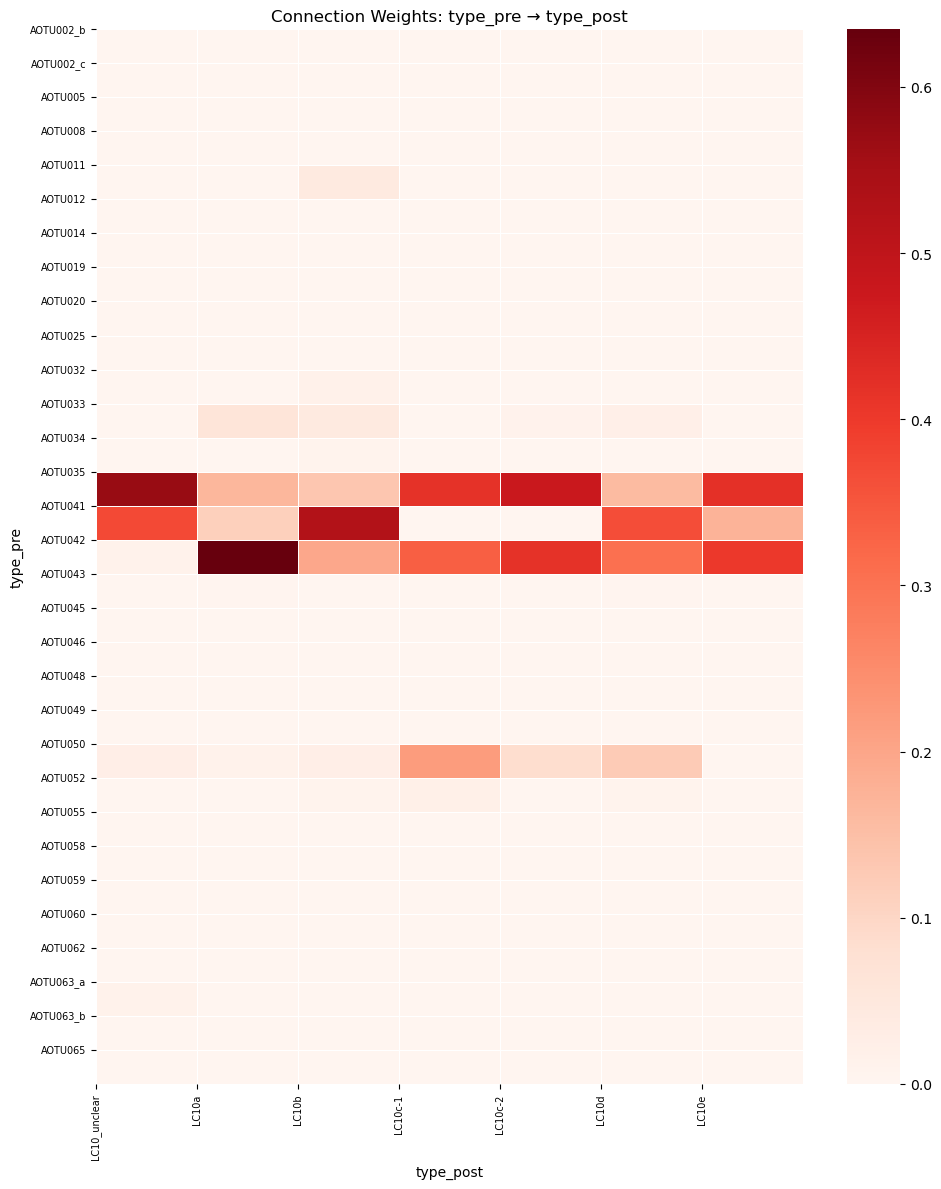

In [106]:
# Pivot the DataFrame to a matrix format
# matrix_df = conn_AOTU_df_type_top.pivot_table(index='type_pre', columns='type_post', values='weight', aggfunc='sum', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 12))
ax = sb.heatmap(norm_matrix_df, cmap='Reds', annot=False, linewidths=0.5)

# Labeling
# Title and axis labels
ax.set_title('Connection Weights: type_pre → type_post')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

# Force all y-ticks to be shown
ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)

# Also ensure all x-ticks are shown if needed
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()
plt.show()